In [118]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling
import datetime
import json
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.utils.multiclass import unique_labels
import joblib
from sklearn.ensemble import RandomForestClassifier

In [63]:
 master = pd.DataFrame([[0]*37],columns=['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'])

In [64]:
for path in glob('Kickstarter_2019-08-15T03_20_03_022Z/*.csv'):
    df = pd.read_csv(path,error_bad_lines=False)
    master = pd.concat([df,master])

In [65]:
master.shape

(207622, 37)

In [66]:
# profile = master.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file="output.html")

In [67]:
master = master.drop(columns = ['friends','is_backing','is_starred','permissions','photo'
                               ,'currency_symbol','urls','source_url','id','name','slug'])

In [68]:
master.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_trailing_code,current_currency,...,location,pledged,profile,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type
0,104,Best value in Cortex-M programming & debugging...,"{""id"":334,""name"":""DIY Electronics"",""slug"":""tec...",4415,US,1507871679,"{""id"":1182544591,""name"":""Dmitry"",""is_registere...",USD,1,USD,...,"{""id"":2455920,""name"":""Mountain View"",""slug"":""m...",4415.0,"{""id"":3182251,""project_id"":3182251,""state"":""in...",0,0,failed,1535230179,1.000000,4415.000000,domestic
1,1,PARENTHOOD - The (Brand New!) Musical Revue is...,"{""id"":284,""name"":""Musical"",""slug"":""theater/mus...",1,GB,1535457814,"{""id"":419452966,""name"":""Emily Moody"",""is_regis...",GBP,0,USD,...,"{""id"":44418,""name"":""London"",""slug"":""london-gb""...",1.0,"{""id"":3458158,""project_id"":3458158,""state"":""in...",0,0,failed,1538052598,1.285752,1.285752,domestic
2,1,porting an app for identifying organic compoun...,"{""id"":332,""name"":""Apps"",""slug"":""technology/app...",1,NL,1525968644,"{""id"":1981812785,""name"":""Matthieu van Sluijs"",...",EUR,0,USD,...,"{""id"":726874,""name"":""The Hague"",""slug"":""the-ha...",1.0,"{""id"":3378332,""project_id"":3378332,""state"":""in...",0,0,failed,1537436992,1.173151,1.173151,domestic
3,62,I am a singer/songwriter from Miami Beach work...,"{""id"":42,""name"":""Pop"",""slug"":""music/pop"",""posi...",8211,US,1314912713,"{""id"":1503975448,""name"":""Cat Shell"",""slug"":""ca...",USD,1,USD,...,"{""id"":2450080,""name"":""Miami Beach"",""slug"":""mia...",8211.0,"{""id"":49312,""project_id"":49312,""state"":""inacti...",1,0,successful,1325310338,1.000000,8211.000000,domestic
4,34,Support your local DIY grunge grrrl band creat...,"{""id"":321,""name"":""Punk"",""slug"":""music/punk"",""p...",1700,US,1501983823,"{""id"":593243081,""name"":""Shrinking Violent"",""is...",USD,1,USD,...,"{""id"":2504633,""name"":""Tempe"",""slug"":""tempe-az""...",1700.0,"{""id"":3098727,""project_id"":3098727,""state"":""in...",1,0,successful,1506720698,1.000000,1700.000000,domestic


In [69]:
# need to get category and sub category for this. 
master['category'].head()[0]

'{"id":334,"name":"DIY Electronics","slug":"technology/diy electronics","position":4,"parent_id":16,"color":6526716,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/technology/diy%20electronics"}}}'

In [70]:
master['created_at'] = master['created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
master['launched_at'] = master['launched_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
master['deadline'] = master['deadline'].apply(lambda x: datetime.datetime.fromtimestamp(x))
#master['deadline'] = master['deadline'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%c'))

In [71]:
master[['created_at','launched_at','deadline','state']].sample(10)

,created_at,launched_at,deadline,state
1775,2015-03-14 08:23:45,2015-03-25 09:56:42,2015-04-23 08:23:00,successful
3026,2018-10-25 12:41:24,2018-10-29 09:02:47,2018-12-01 12:00:00,successful
967,2015-07-17 11:34:21,2015-11-02 13:32:23,2015-12-30 21:01:00,successful
934,2019-07-06 06:13:06,2019-07-15 00:02:16,2019-08-14 00:02:16,successful
1055,2016-04-24 19:19:46,2016-04-28 14:54:09,2016-05-28 14:54:09,failed
3387,2013-05-14 17:19:11,2013-05-18 08:04:24,2013-06-01 08:04:24,successful
2765,2015-06-29 09:21:37,2015-07-31 02:37:57,2015-08-30 02:37:57,successful
3352,2018-11-13 03:09:04,2018-12-05 12:43:25,2019-01-06 14:59:00,failed
2172,2012-05-26 08:47:58,2012-05-29 12:37:49,2012-07-03 12:37:49,successful
272,2019-03-11 16:38:46,2019-05-13 08:03:15,2019-07-12 08:03:15,successful


In [72]:
master['category'] = master['category'].astype(str)

In [73]:
master['category'] = master['category'].apply(json.loads)

In [74]:
df = pd.concat([master.drop(['category'], axis=1), master['category'].apply(pd.Series)], axis=1)

In [75]:
df[['slug','name']].head()

,slug,name
0,technology/diy electronics,DIY Electronics
1,theater/musical,Musical
2,technology/apps,Apps
3,music/pop,Pop
4,music/punk,Punk


In [76]:
df=df.drop(columns = ['name','parent_id','position','id','urls','color','state_changed_at'],axis =1)

In [77]:
new = df['slug'].str.split("/", n = 1, expand = True) 
df["category"]= new[0]
df["sub-category"] = new[1]
df.drop(columns =['slug'], inplace = True)

In [78]:
df[['category','sub-category']].head()

,category,sub-category
0,technology,diy electronics
1,theater,musical
2,technology,apps
3,music,pop
4,music,punk


In [79]:
df['campaign_duration'] = df['deadline'] - df['launched_at'] 
#type(df['launched_at'].head()[0])

In [80]:
df[['campaign_duration','deadline','launched_at','state']].head()

,campaign_duration,deadline,launched_at,state
0,60 days,2018-08-25 13:49:39,2018-06-26 13:49:39,failed
1,30 days,2018-09-27 05:49:57,2018-08-28 05:49:57,failed
2,60 days,2018-09-20 02:49:52,2018-07-22 02:49:52,failed
3,60 days,2011-12-30 21:45:36,2011-10-31 21:45:36,successful
4,52 days,2017-09-29 14:31:37,2017-08-08 14:31:37,successful


In [81]:
df['campaign_launch_delay'] = df['launched_at'] - df['created_at'] 

In [82]:
df['campaign_launch_delay'].head()

0   256 days 15:35:00
1     0 days 00:46:23
2    72 days 17:39:08
3    60 days 07:13:43
4     2 days 19:47:54
Name: campaign_launch_delay, dtype: timedelta64[ns]

In [83]:
df2 = df[df['state'] != ('live')]

In [84]:
df2['state'].value_counts()

successful    118183
failed         74143
canceled        8456
suspended        632
0                  1
Name: state, dtype: int64

In [85]:
df3 = df2[df2['state'] != 0]

In [86]:
df3['state'].value_counts()

successful    118183
failed         74143
canceled        8456
suspended        632
Name: state, dtype: int64

In [87]:
df3=df3.drop(columns = ['blurb'],axis =1)

In [88]:
df3['deadline'] = pd.to_datetime(df3['deadline'], infer_datetime_format=True)
df3['launched_at'] = pd.to_datetime(df3['launched_at'], infer_datetime_format=True)
#df3['campaign_launch_delay'] = pd.to_datetime(df3['campaign_launch_delay'], infer_datetime_format=True)
df3['created_at'] = pd.to_datetime(df3['created_at'], infer_datetime_format=True)

In [89]:
df3['campaign_duration_days']= df3['campaign_duration'].dt.days

In [90]:
df3['campaign_launch_delay_days']=df3['campaign_launch_delay'].dt.days

In [91]:
df3[['campaign_launch_delay_days','campaign_launch_delay']].head()

,campaign_launch_delay_days,campaign_launch_delay
0,256,256 days 15:35:00
1,0,0 days 00:46:23
2,72,72 days 17:39:08
3,60,60 days 07:13:43
4,2,2 days 19:47:54


In [92]:
df3['campaign_launch_delay_secs']=df3['campaign_launch_delay'].dt.seconds

In [93]:
df3['launched_at_year'] = df3['launched_at'].dt.year
df3['launched_at_month'] = df3['launched_at'].dt.month
df3['launched_at_day'] = df3['launched_at'].dt.day
df3['launched_at_hour'] = df3['launched_at'].dt.hour

In [94]:
df3['deadline_year'] = df3['deadline'].dt.year
df3['deadline_month'] = df3['deadline'].dt.month
df3['deadline_day'] = df3['deadline'].dt.day
df3['deadline_hour'] = df3['deadline'].dt.hour

In [95]:
df3['created_at_year'] = df3['created_at'].dt.year
df3['created_at_month'] = df3['created_at'].dt.month
df3['created_at_day'] = df3['created_at'].dt.day
df3['created_at_hour'] = df3['created_at'].dt.hour

In [96]:
df3=df3.drop(columns = ['deadline','launched_at','campaign_launch_delay','created_at',
                       'campaign_duration'],axis =1)

In [97]:
df3.columns

Index([             'backers_count',   'converted_pledged_amount',
                          'country',                    'creator',
                         'currency',     'currency_trailing_code',
                 'current_currency',      'disable_communication',
                          'fx_rate',                       'goal',
                     'is_starrable',                   'location',
                          'pledged',                    'profile',
                        'spotlight',                 'staff_pick',
                            'state',            'static_usd_rate',
                      'usd_pledged',                   'usd_type',
                                  0,                   'category',
                     'sub-category',     'campaign_duration_days',
       'campaign_launch_delay_days', 'campaign_launch_delay_secs',
                 'launched_at_year',          'launched_at_month',
                  'launched_at_day',           'launched_at_ho

In [98]:
numerical_features = ['fx_rate','goal',
                     'static_usd_rate','launched_at_year','campaign_duration_days',
                     'launched_at_month','launched_at_day','launched_at_hour','deadline_year',
                     'deadline_month','created_at_year','created_at_month','created_at_day',
                     'created_at_hour','campaign_launch_delay_days','campaign_launch_delay_secs']
cat_features = ['country','creator','currency','current_currency','location',
               'usd_type','category','sub-category']
bool_features = ['currency_trailing_code','staff_pick']

In [99]:
df3['created_at_year'].value_counts()

2015    36896
2018    33011
2016    29127
2017    28778
2014    28476
2019    19417
2013    11219
2012     8951
2011     3933
2010     1362
2009      244
Name: created_at_year, dtype: int64

In [100]:
df4 = df3[df3['state'] != 'canceled']

In [101]:
df5 = df4[df4['state'] != 'suspended']

In [102]:
df5=df5.drop(columns = [0 , 'disable_communication', 'is_starrable', 'profile','spotlight',
                       'backers_count','converted_pledged_amount','pledged','usd_pledged'],axis =1)

In [103]:
nunique = df5.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
#df6 = X_test_encoded.drop(cols_to_drop, axis=1)

In [104]:
cols_to_drop

Index([], dtype='object')

**Test Train Split**

In [105]:
train = df5[df5['launched_at_year'] != 2019]
test = df5[df5['launched_at_year'] == 2019]

In [106]:
target = 'state'
X_train = train.drop(columns=target)
X_test = test.drop(columns=target)
y_test = test[target]
y_train = train[target]

In [107]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((169383, 28), (22943, 28), (169383,), (22943,))

In [108]:
y_pred_base = np.full_like(y_test,fill_value = 'successful')

In [109]:
y_pred_base.shape

(22943,)

In [110]:
print('baseline accuracy:', accuracy_score(y_test, y_pred_base))

baseline accuracy: 0.8069999564137209


In [106]:
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())])
# ordinal_transformer = Pipeline(steps=[
#     #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('ord', ce.OrdinalEncoder())]) 
# #boolean_transformer = Pipeline(steps=[
#  #   ('imputer', SimpleImputer(strategy='most_frequent'))])
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features),
#         ('one', ordinal_transformer, cat_features)])

In [178]:
# classification = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('rf', RandomForestClassifier(n_estimators=200, min_samples_split=3,
#                              criterion='gini', max_features='auto', oob_score=True,
#                              random_state=5, n_jobs=-1,class_weight = 'balanced'))])

In [179]:
# model = XGBClassifier(n_jobs=-1, random_state=42)
# param_dist = {'max_depth': randint(3,12),
#               'learning_rate': uniform(0,1),
#               'n_estimators': randint(200, 1500),
#               'min_child_weight': randint(1,10),
#               'gamma': randint(0,5),
#               'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#               'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
#               }

# search = RandomizedSearchCV(model,
#                             param_distributions=param_dist,
#                             n_iter=,
#                             cv=5,
#                             scoring='accuracy',
#                             verbose=10,
#                             return_train_score=True)

# search.fit(X_train, y_train)
# print('Best hyperparameters', search.best_params_)
# print('Best score', search.best_score_)

In [180]:
# imputer = SimpleImputer(stratergy = 'constant')

In [111]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.fit_transform(X_test)

In [112]:
# model = XGBClassifier(n_estimators=1191,min_child_weight=6,max_depth=10,colsample_bytree=0.7,
#                           gamma=3,learning_rate=0.9824937724774578,subsample=1,
#                           random_state=42, n_jobs=-1)

In [114]:
 model = XGBClassifier(n_estimators=1191,max_depth=10,random_state=42, n_jobs=-1)

In [119]:
joblib.dump( model, "xgb1.joblib.dat")

['xgb1.joblib.dat']

In [120]:
loaded_model = joblib.load("xgb1.joblib.dat")

In [48]:
# model = RandomForestClassifier(n_estimators=200, min_samples_split=3,
#                             criterion='gini', max_features='auto', oob_score=True,
#                               random_state=5, n_jobs=-1,class_weight = 'balanced')

In [49]:
#  X_train_encoded.shape

(169383, 28)

In [50]:
#  X_test_encoded.shape

(22943, 28)

In [119]:
#X_test_encoded

In [116]:
# nunique = X_test_encoded.apply(pd.Series.nunique)
# cols_to_drop = nunique[nunique == 1].index
# df6 = X_test_encoded.drop(cols_to_drop, axis=1)

In [186]:
# df6.shape

In [125]:
# nunique1 = X_train.apply(pd.Series.nunique)
# cols_to_drop1 = nunique[nunique == 1].index
# #df6 = X_test_encoded.drop(cols_to_drop, axis=1)

In [187]:
# cols_to_drop1

In [188]:
# cols_to_drop

In [189]:
# X_train['is_starrable'].value_counts()

In [52]:
# model.fit(X_train_encoded, y_train)

In [191]:
# pre = Pipeline(steps=[('preprocessor', preprocessor)])

In [192]:
# X_test_encoded = pre.fit_transform(X_test)

In [193]:
# X_test_encoded.shape

In [194]:
# y_train.value_counts()

In [195]:
# y_test.value_counts()

In [196]:
# classification.named_steps['rf'].input_features_

In [197]:
# X_test.columns

In [121]:
y_pred = loaded_model.predict(X_test_encoded)
print('test accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

XGBoostError: need to call fit or load_model beforehand

In [53]:
# np.unique(y_pred)

array(['failed', 'successful'], dtype=object)

In [54]:
# np.unique(y_test)

array(['failed', 'successful'], dtype=object)

In [103]:
# choosing hyperparamters
model = XGBClassifier()

classification_hyp = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', XGBClassifier(n_jobs=-1,random_state = 42))])

param_dist = {'model__max_depth': randint(3,12),
              'model__n_estimators': randint(200, 1500),
              'model__min_child_weight': randint(1,10),
              'model__subsample': [0.6, 0.7, 0.8, 0.9, 1],
              'model__learning_rate': uniform(0,1),
              'model__gamma': randint(0,5),
              'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
              }

search = RandomizedSearchCV(classification_hyp,
                            param_distributions=param_dist,
                            n_iter=4,
                            cv=3,
                            scoring='accuracy',
                            verbose=10,
                            return_train_score=True)

search.fit(X_train, y_train)
print('Best hyperparameters', search.best_params_)
print('Best score', search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV] model__colsample_bytree=1, model__gamma=1, model__learning_rate=0.673508416309833, model__max_depth=8, model__min_child_weight=8, model__n_estimators=821, model__subsample=0.6 


/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=1, model__gamma=1, model__learning_rate=0.673508416309833, model__max_depth=8, model__min_child_weight=8, model__n_estimators=821, model__subsample=0.6, score=0.6810598278488187, total= 4.3min
[CV] model__colsample_bytree=1, model__gamma=1, model__learning_rate=0.673508416309833, model__max_depth=8, model__min_child_weight=8, model__n_estimators=821, model__subsample=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=1, model__gamma=1, model__learning_rate=0.673508416309833, model__max_depth=8, model__min_child_weight=8, model__n_estimators=821, model__subsample=0.6, score=0.7685836240945078, total= 4.3min
[CV] model__colsample_bytree=1, model__gamma=1, model__learning_rate=0.673508416309833, model__max_depth=8, model__min_child_weight=8, model__n_estimators=821, model__subsample=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.9min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=1, model__gamma=1, model__learning_rate=0.673508416309833, model__max_depth=8, model__min_child_weight=8, model__n_estimators=821, model__subsample=0.6, score=0.7615125752745306, total= 4.2min
[CV] model__colsample_bytree=1, model__gamma=3, model__learning_rate=0.24787139771247935, model__max_depth=9, model__min_child_weight=2, model__n_estimators=873, model__subsample=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.4min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=1, model__gamma=3, model__learning_rate=0.24787139771247935, model__max_depth=9, model__min_child_weight=2, model__n_estimators=873, model__subsample=1, score=0.577521164677128, total= 3.8min
[CV] model__colsample_bytree=1, model__gamma=3, model__learning_rate=0.24787139771247935, model__max_depth=9, model__min_child_weight=2, model__n_estimators=873, model__subsample=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 17.2min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=1, model__gamma=3, model__learning_rate=0.24787139771247935, model__max_depth=9, model__min_child_weight=2, model__n_estimators=873, model__subsample=1, score=0.7990825525584031, total= 3.7min
[CV] model__colsample_bytree=1, model__gamma=3, model__learning_rate=0.24787139771247935, model__max_depth=9, model__min_child_weight=2, model__n_estimators=873, model__subsample=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.0min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=1, model__gamma=3, model__learning_rate=0.24787139771247935, model__max_depth=9, model__min_child_weight=2, model__n_estimators=873, model__subsample=1, score=0.7984059511158342, total= 3.6min
[CV] model__colsample_bytree=0.6, model__gamma=3, model__learning_rate=0.923802741121822, model__max_depth=9, model__min_child_weight=6, model__n_estimators=906, model__subsample=0.9 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 24.6min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=0.6, model__gamma=3, model__learning_rate=0.923802741121822, model__max_depth=9, model__min_child_weight=6, model__n_estimators=906, model__subsample=0.9, score=0.6700258580992526, total= 3.1min
[CV] model__colsample_bytree=0.6, model__gamma=3, model__learning_rate=0.923802741121822, model__max_depth=9, model__min_child_weight=6, model__n_estimators=906, model__subsample=0.9 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 27.9min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=0.6, model__gamma=3, model__learning_rate=0.923802741121822, model__max_depth=9, model__min_child_weight=6, model__n_estimators=906, model__subsample=0.9, score=0.7792989851401853, total= 3.1min
[CV] model__colsample_bytree=0.6, model__gamma=3, model__learning_rate=0.923802741121822, model__max_depth=9, model__min_child_weight=6, model__n_estimators=906, model__subsample=0.9 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 31.1min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=0.6, model__gamma=3, model__learning_rate=0.923802741121822, model__max_depth=9, model__min_child_weight=6, model__n_estimators=906, model__subsample=0.9, score=0.7750442791356713, total= 3.1min
[CV] model__colsample_bytree=0.7, model__gamma=3, model__learning_rate=0.9824937724774578, model__max_depth=10, model__min_child_weight=6, model__n_estimators=1191, model__subsample=1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 34.3min remaining:    0.0s
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=0.7, model__gamma=3, model__learning_rate=0.9824937724774578, model__max_depth=10, model__min_child_weight=6, model__n_estimators=1191, model__subsample=1, score=0.6797846339130743, total= 4.4min
[CV] model__colsample_bytree=0.7, model__gamma=3, model__learning_rate=0.9824937724774578, model__max_depth=10, model__min_child_weight=6, model__n_estimators=1191, model__subsample=1 


/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=0.7, model__gamma=3, model__learning_rate=0.9824937724774578, model__max_depth=10, model__min_child_weight=6, model__n_estimators=1191, model__subsample=1, score=0.7812295212624644, total= 4.5min
[CV] model__colsample_bytree=0.7, model__gamma=3, model__learning_rate=0.9824937724774578, model__max_depth=10, model__min_child_weight=6, model__n_estimators=1191, model__subsample=1 


/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



[CV]  model__colsample_bytree=0.7, model__gamma=3, model__learning_rate=0.9824937724774578, model__max_depth=10, model__min_child_weight=6, model__n_estimators=1191, model__subsample=1, score=0.7719447396386823, total= 4.5min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 48.2min finished
/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



Best hyperparameters {'model__colsample_bytree': 0.7, 'model__gamma': 3, 'model__learning_rate': 0.9824937724774578, 'model__max_depth': 10, 'model__min_child_weight': 6, 'model__n_estimators': 1191, 'model__subsample': 1}
Best score 0.7443190875117338


In [109]:
model_hyp = XGBClassifier(n_estimators=1191,min_child_weight=6,max_depth=10,colsample_bytree=0.7,
                          gamma=3,earning_rate=0.9824937724774578,subsample=1,
                          random_state=42, n_jobs=-1)

In [110]:
y_pred = model_hyp.predict(X_test_encoded)
print('test accuracy:', accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

XGBoostError: need to call fit or load_model beforehand

In [56]:
cm = confusion_matrix(y_test,y_pred)

In [57]:
def plot_confusion_matrix(y_true,y_pred,normalize=False):
    columns = [f'Predicted "{c}"'for c in unique_labels(y_pred)]
    index_names = [f'Actual "{c}"'for c in unique_labels(y_true)]
    cm = confusion_matrix(y_true,y_pred)
    if normalize:
        cm=cm/cm.sum(axis=1).reshape(y_true.nunique(),1)
    df = pd.DataFrame(cm,columns = columns,index = index_names)
    sns.heatmap(df,cmap='viridis',annot=True,fmt='.2f');

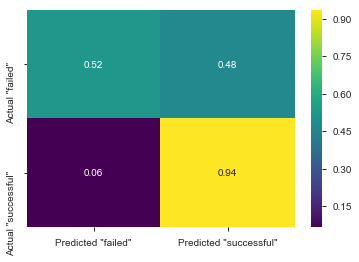

In [58]:
plot_confusion_matrix(y_test,y_pred,normalize=True)

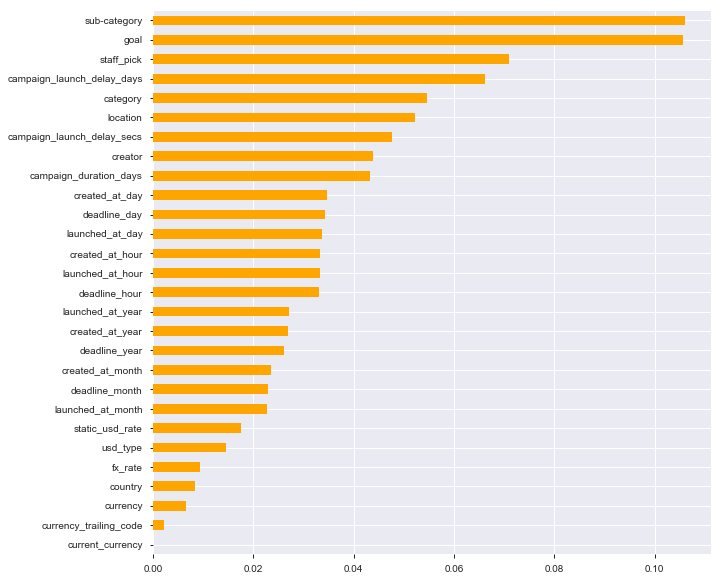

In [55]:
# Feature Importance
plt.figure(figsize=(10,10))
importances = pd.Series(model.feature_importances_, X_test.columns).sort_values(ascending=False)
importances = importances.sort_values()
importances.plot.barh(color='orange');

Visuals

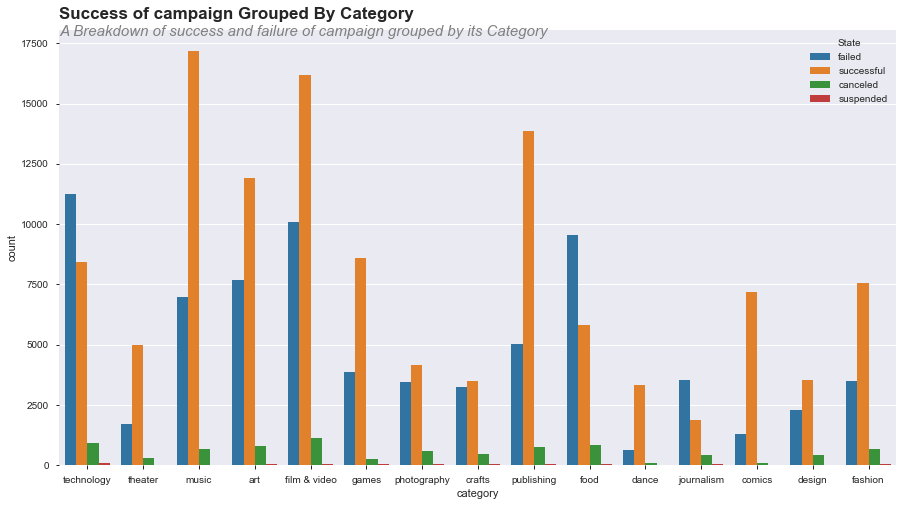

In [54]:
# Using the five thirty eight style
plt.style.context('fivethirtyeight')
#colors = ['#fff100', '#ff8c00', '#e81123', '#ec008c']
#sns.set_palette(colors, 4)
plt.figure(figsize=(15,8))

# Setting plot and details
ax = sns.countplot(x = "category", hue="state", data=df3)
ax.text(s="Success of campaign Grouped By Category", y=18500, x=-0.5, fontsize=17, fontweight='semibold');
ax.text(s="A Breakdown of success and failure of campaign grouped by its Category", y=17800, x=-0.5, fontsize=15, fontstyle='italic', color='grey')
l = ax.legend()
l.set_title('State')
sns.despine(ax=ax, left=True)
# ax.set_ylabel("");
# ax.set_xlabel("");

In [58]:
#ratio of success to fail in each category
#fail = df3[df3['state' == 'failed']]
fail = df3['state'=='failed']
success = df3['state'=='successful']
cancel = df3['state'=='canceled']

In [68]:
film_video = df3[df3['category']=='film & video']
music = df3['category'=='music']
technology = df3['category'=='technology']
art = df3['category'=='art']
publishing = df3['category'=='publishing']
food = df3['category'=='food']
games = df3['category'=='games']
fashion = df3['category'=='fashion']
comics = df3['category'=='comics']
photography = df3['category'=='photography']
crafts = df3['category'=='crafts']
theater = df3['category'=='theater']
design = df3['category'=='design']
journalism = df3['category'=='journalism']
dance = df3['category'=='dance']

In [81]:
(film_video[film_video['state']=='failed']['state'].count())/(film_video['state'].count())

0.36783329075581184